<a href="https://colab.research.google.com/github/EdwardMMiller/Data-Mining-Project---Fall-2022/blob/main/News_Classifier_COLAB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **NEWS CLASSIFIER**

## DATA MINING - FALL 2022
## CUNY GRADUATE CENTER
## Edward Miller

## Overview

Over the past few decades, news sources have drastically shifted from print media to
online sites due to the widespread adoption of the internet by the general public. As a
consequence of this shift, it has become easier for news articles from untrustworthy
sources to pass themselves as real, and cause disinformation to spread rapidly. This
disinformation can cause widespread damage to a society. A relatively recent example of this is the misinforamtion spread about COVID-19 vaccines, which cause many people to avoid the vaccine and die from infection as a result. Therefore, it is now
more important than ever to develop sound methods for determining whether a news
story is real, or not. The intent of this project will be to use deep learning in order to train a
model that can correctly classify a list of news stories as real or not real.

## Goals
1. Train a deep learning model for binary classification to correctly classify whether a
news story is real
2. Test Trained Model on a dataset to determine how well it differentiates between the
two classes, and report findings.

## Dataset
The dataset, as well as the direct inspiration for this project, comes from the following kaggle
website, and the author of the code has some good insights that will be reused here as well.

https://www.kaggle.com/code/urkchar/determine-if-news-is-fake-or-real/notebook

Progress will be updated through Github here:

https://github.com/EdwardMMiller/Data-Mining-Project---Fall-2022/new/main

In [1]:
!pip install pandas
!pip install numpy
!pip install tensorflow==2.9.2'
!pip install keras
!pip3 install seaborn
!pip3 install newspaper3k


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/bin/bash: -c: line 0: unexpected EOF while looking for matching `''
/bin/bash: -c: line 1: syntax error: unexpected end of file
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 211 kB 8.0 MB/s 
     |████████████████████████████████| 7.4 MB 77.3 MB/s 
     |████████████████████████████████| 81 kB 10.6 MB/s 
     |████████████████████████████████| 93 kB 2.9 MB/s 
  Created wheel for tinysegmenter: filename=tinysegmenter-0.3-py3-none-any.whl size=13552 sha256=4b0c6b0c35be846f3aef68cbea4c7e404479dd851eae27ee174

In [2]:
from absl import logging
import tensorflow as tf
import tensorflow_hub as hub
import keras as K
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV, train_test_split
from newspaper import Article
import re
import zipfile
# library imports

In [3]:
URL_T = 'https://raw.githubusercontent.com/EdwardMMiller/Data-Mining-Project---Fall-2022/main/True.csv'
URL_F = "https://raw.githubusercontent.com/EdwardMMiller/Data-Mining-Project---Fall-2022/main/Fake.csv"
# getting data from Github

True_df = pd.read_csv(URL_T)
Fake_df = pd.read_csv(URL_F)
# getting the csv files into dataframe

print("Number of rows in True_df = ", True_df.shape[0])
print("Number of rows in Fake_df = ", Fake_df.shape[0])
print("Number of columns in True_df = ", True_df.shape[1])
print("Number of columns in Fake_df = ", Fake_df.shape[1])
# Checking number of rows and columns in each dataset

columns_list_T = True_df.columns.tolist()
columns_list_F = Fake_df.columns.tolist()
print("List of columns in True_df", columns_list_T)
print("List of columns in False_df", columns_list_T)
# checking to see if columns are the same
#%%
def data_file_explore(file, df):

  """
    This is a simple function designed to do surface level
    exploration of the data in a csv file. It will print the
    first five rows of a data file, number of rows and columns in the data file
    number of unique values in the data value, and the number of missing values
    in the data file. It also inputs the minimum, maximum, mean and median
    for the numeric columns, and then finds the mode for the column along with
    the number of times it appears in that column. Finally, it also gets the
    most frequent string found for the string columns along with the number of
    times that string is found in the column. It is assumed that the data
    that is being worked with is either numeric or a string.

  Args:
    file = string referencing the filename
    df = a data frame created from reading in the file
  Returns:
    none
  """
  
  print("*********************** FILE NAME: %s ***********************\n" %file)

  # This is just a file header

  print("First five rows in file: %s\n" %file)
  display(df.head())
  # looking at the first five rows of the data

  print("\nData types present in file: %s\n" %file)
  print(df.dtypes)
  # looking at data types found in the dataframe

  print("\nNumber of rows and columns in file: %s\n" %file)
  display(df.shape)
  # Getting the size of the dataset

  print("\nNumber of unique values for each column in file: %s\n" %file)
  display(df.nunique())
  # Looking at number of unique values

  print("\nCount of missing values in file: %s\n" %file)
  display(df.isnull().sum())
  print("")
  # Counting the missing values in the datasets

  for col in df.select_dtypes(include=np.number):
    # Looping through numeric columns in data frame a
      #print("Min for col %s = %s" %(col, df[col].min()))
      #print("Max for col %s = %s" %(col, df[col].max()))
    print("Numerical Stats for column - '%s' " % col)
    print("--------------------------------------------")
    (print("Min: %s Mean: %s"
           %(df[col].min(), df[col].mean() )))
    print("Max: %s Median: %s" %(df[col].max(), df[col].median()))
    # Printing the minimum, maximum, mean and median

    col_mode = df[col].value_counts().idxmax()
    # get the most frequent value in the column
    freq = df[col].value_counts()[col_mode]
    # get the count of the most frequent value in the column

    if freq > 1:
      print("Most frequent value: %s found in column %s times.\n" %(col_mode,freq))
    else:
      print("No value repetitions found in column\n")
      # Only returning the most frequent value if it appears more than once

  for col in df.select_dtypes(include=object):
      # Only looking at columns with strings now
    print("Frequency counts for string column - '%s' " % col)
    print("--------------------------------------------------")
    col_mode = df[col].value_counts().idxmax()
      # get the most frequent value in the column
    freq = df[col].value_counts()[col_mode]
      # get the count of the most frequent value in the column
    if freq > 1:
      (print("Most frequent string value: '%s' found in column %s times.\n"
               %(col_mode,freq)))
    else:
      print("No value repetitions found in column\n")
        # Only returning the most frequent value if it appears more than once

data_file_explore('True.csv', True_df)
data_file_explore('Fake.csv', Fake_df)


Number of rows in True_df =  21417
Number of rows in Fake_df =  23481
Number of columns in True_df =  4
Number of columns in Fake_df =  4
List of columns in True_df ['title', 'text', 'subject', 'date']
List of columns in False_df ['title', 'text', 'subject', 'date']
*********************** FILE NAME: True.csv ***********************

First five rows in file: True.csv



,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"



Data types present in file: True.csv

title      object
text       object
subject    object
date       object
dtype: object

Number of rows and columns in file: True.csv



(21417, 4)


Number of unique values for each column in file: True.csv



title      20826
text       21192
subject        2
date         716
dtype: int64


Count of missing values in file: True.csv



title      0
text       0
subject    0
date       0
dtype: int64


Frequency counts for string column - 'title' 
--------------------------------------------------
Most frequent string value: 'Factbox: Trump fills top jobs for his administration' found in column 14 times.

Frequency counts for string column - 'text' 
--------------------------------------------------
Most frequent string value: '(Reuters) - Highlights for U.S. President Donald Trump’s administration on Thursday: The United States drops a massive GBU-43 bomb, the largest non-nuclear bomb it has ever used in combat, in Afghanistan against a series of caves used by Islamic State militants, the Pentagon says. Trump says Pyongyang is a problem that “will be taken care of” amid speculation that North Korea is on the verge of a sixth nuclear test. Military force cannot resolve tension over North Korea, China warns, while an influential Chinese newspaper urges Pyongyang to halt its nuclear program in exchange for Beijing’s protection. The Trump administration is focusing its North Korea stra

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"



Data types present in file: Fake.csv

title      object
text       object
subject    object
date       object
dtype: object

Number of rows and columns in file: Fake.csv



(23481, 4)


Number of unique values for each column in file: Fake.csv



title      17903
text       17455
subject        6
date        1681
dtype: int64


Count of missing values in file: Fake.csv



title      0
text       0
subject    0
date       0
dtype: int64


Frequency counts for string column - 'title' 
--------------------------------------------------
Most frequent string value: 'MEDIA IGNORES Time That Bill Clinton FIRED His FBI Director On Day Before Vince Foster Was Found Dead' found in column 6 times.

Frequency counts for string column - 'text' 
--------------------------------------------------
Most frequent string value: ' ' found in column 626 times.

Frequency counts for string column - 'subject' 
--------------------------------------------------
Most frequent string value: 'News' found in column 9050 times.

Frequency counts for string column - 'date' 
--------------------------------------------------
Most frequent string value: 'May 10, 2017' found in column 46 times.



# **OVERVIEW OF DATA SETS**

A cursory glance at the data shows that there are no missing values in either data set and that both column types
are the same along with matching data types. There are no numerical columns her, only text and dates. However, the author of the original project points out that the **True.csv** file  shows **WASHINGTON (Reuters) - ** or **SEATTLE/WASHINGTON (Reuters)** before the news articles. Also, there are **6** unique values for **'subject'** in the **Fake.csv** file and only **2** unique values for **'subject'** in the **True.csv**, which might cause the model while training the dataset to mainly look for these two things to determine whether the news article is fake. We will want to remove these things in order to ensure that it's not so obvious which one is which, and also ensure that the model will be able to work when classifying news stories that do not have this format, as one could then easily add the <Reuters> term to a fake news story, in order to trick the model into classifying it is as true.

In [4]:
cnt = 0
for row in True_df.index:
  if "(Reuters)" in True_df.loc[row]['text']:
     cnt = cnt + 1
print("Count of rows in True_df containing term (Reuters) = %s"% cnt )
print("Number of rows in True_df data frame = ", True_df.shape[0])
print("Percentage of rows in True_df containing (Reuters) = %s"% (cnt/True_df.shape[0]*100) )
print('')
# Counting the number of instances that contain the string "(Reuters)" in True_df

cnt = 0
for row in Fake_df.index:
  if "(Reuters)" in Fake_df.loc[row]['text']:
     cnt = cnt + 1
print("Count of rows in Fake_df containing term (Reuters) = %s"% cnt )
print("Number of rows in Fake_df data frame = ", Fake_df.shape[0])
print("Percentage of rows in Fake_df containing (Reuters) = %s"% (cnt/Fake_df.shape[0]*100) )
# Counting the number of instances that contain the string "(Reuters)" in Fake_df

Count of rows in True_df containing term (Reuters) = 21247
Number of rows in True_df data frame =  21417
Percentage of rows in True_df containing (Reuters) = 99.20623803520567

Count of rows in Fake_df containing term (Reuters) = 9
Number of rows in Fake_df data frame =  23481
Percentage of rows in Fake_df containing (Reuters) = 0.038328861632809505


As the original author also pointed out, this is something that needs to be addressed with the data before putting it into the model, as one can clearly see that over **99%** of the **True_df** rows contain the term **'(Reuters)'** and under **4%** of the rows in Fake_df contain this term. Let us also look at the 'subjects' column.

In [5]:
display(True_df['subject'].unique())
display(Fake_df['subject'].unique())
# looking at the unique values in the 'subjects' column

array(['politicsNews', 'worldnews'], dtype=object)

array(['News', 'politics', 'Government News', 'left-news', 'US_News',
       'Middle-east'], dtype=object)

Using the **'subjects'** column in the model would be a dead give-away to the model as the unique values in the **Fake_df** and **True_df** are totally different and seeing one subject or the other would train the model to look for that subject when classifying the news article as real or fake.  Therefore, the text data needs to be pre-processed and the subject column needs to be removed as well. Also, in order to get a better look at just the text itself to see if a model can determine which class it belongs to, the date column will be removed as well.

In [6]:
def text_clean(string):
  """
  This function removes this pattern "^[A-Z/]+ \(Reuters\) - "
  from a text string
  :param string: A single string
  :return:  A single string with the pattern removed
  """
  reuters_pattern = "^[A-Z/]+ \(Reuters\) - "
  # String to remove at the start of True_df looks like
  # WASHINGTON (Reuters) - so saving this pattern
  return re.sub(reuters_pattern, "", string)
##########################################################################
test_string1 = True_df.loc[0]['text']
print("String before text_clean function applied\n")
print(test_string1)
print('')
# getting a test string to test function

print("String after text_clean function applied\n")
print(text_clean(test_string1))
print('')
# testing function to see if it removes string

def df_pre_processor(df_t, df_f, Shuffle = True):
  """ This is a basic pre-processing function that takes in
  the two dataframes True_df and Fake_df, adds correct labels
  to each, combines them, cleans the text column, removes unneeded
  columns and shuffles the dataframe

  :param df_t: a dataframe containing all true news articles
  :param df_f: a dataframe containing all fake news articles
  :param  Shuffle: bool = True
  :return: a pre-processed data frame combined from df_t & df_f
  """
  df_t['label'] = True
  df_f['label'] = False
  # adding correct labels to each

  df = pd.concat([df_t, df_f], axis=0)
  df['text'] = df['text'] .apply(text_clean)
  # combining both data frames and
  # applying text clean to the text column

  df = df.drop(["subject", 'date'],axis = 1)
  # removing two columns from df

  if Shuffle:
     df = shuffle(df).reset_index(drop=True)
  # shuffles the dataframe before returning it
  return df
##########################################################################
df_combined = df_pre_processor(True_df.copy(), Fake_df.copy())
# putting both dataframes in pre-processing function
display(df_combined.head())
# looking at new data frame
bool_test = True_df.shape[0] \
            + Fake_df.shape[0] \
            == df_combined.shape[0]
print("Will print %sTrue%s if total rows are equal - %s" % ("'","'",bool_test))
# checking to make sure new data frame has correct dimensions

String before text_clean function applied

WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non-defense “discretionary

,title,text,label
0,Pentagon: Will provide Trump options if North ...,The Pentagon said on Monday that it would prov...,True
1,New Zealand likely to announce new government ...,New Zealand acting Prime Minister Bill English...,True
2,Trump picks southerner over Midwest candidate ...,U.S. President-elect Donald Trump officially a...,True
3,Top Senate Republican rejects Trump filibuster...,The top Republican in the U.S. Senate on Tuesd...,True
4,SOCIOPATHIC LIAR: Hillary Hid SERIOUS Health I...,In the end it really all comes down to charact...,False


Will print 'True' if total rows are equal - True


We now have a dataframe that can be used for the next steps. Our next step is to separate the data in train and test sections and the labels will need to be separated as well.  

In [7]:
columns_list = df_combined.columns[::].tolist()
columns_list.remove('label')
# saving columns list for features minus label
train_x, test_x, train_y, test_y = train_test_split(df_combined[columns_list],
                                                    df_combined['label'],
                                                    test_size=0.2,
                                                    random_state=5)
# Splitting data in train and test groups
display(train_x)
display(train_y)
display(test_x)
display(test_y)

,title,text
41124,The Law Says Donald Trump Can Already Be Impe...,The moment Donald Trump is sworn in as preside...
22642,WATCH: FEMALE CAB DRIVER Entering Mandalay Bay...,"Cori Langdon, a Las Vegas cab driver recorded ..."
5161,#PhoenixRally ROCKS! WATCH: President Trump Ca...,President Trump spoke to a huge and enthusiast...
25434,Illinois lawmaker's daughter charged in politi...,(Reuters) - A daughter of an Illinois state re...
2009,MASS MIGRATION OR INFRASTRUCTURE…CHOOSE ONE: O...,The truth in the information below is so dead ...
...,...,...
5520,Russian hacker wanted by U.S. tells court he w...,A Russian hacker arrested in Spain on a U.S. w...
35814,MULTI-MILLIONAIRE #NFL PLAYERS Take Knee Durin...,Does anyone else find it ironic that black mul...
20463,Indonesian court recognizes native religions i...,Indonesia s Constitutional Court on Tuesday af...
18638,DEMOCRAT HEADS SET TO EXPLODE: Feds Waive Envi...,The Department of Homeland Security announced ...


41124    False
22642    False
5161     False
25434     True
2009     False
         ...  
5520      True
35814    False
20463     True
18638    False
35683    False
Name: label, Length: 35918, dtype: bool

,title,text
10128,"As debt limit looms, House leaders eye biparti...",Congressional leaders are quietly working on a...
43165,Gennifer Flowers won't attend U.S. presidentia...,Republican vice presidential candidate Mike Pe...
14627,Trump Seriously Just Said Waterboarding Is Ok...,"On the campaign trail, Donald Trump said he wa..."
17654,“We are progressive”: Activist Defends $190K P...,Immigration advocate Roberto Hernandez joined ...
28412,New York attorney general looking at Eric Trum...,(Reuters) - New York’s attorney general is loo...
...,...,...
16304,OOPS! DOCTOR DRAGGED Off United Airlines Fligh...,Is it possible the good Dr. Dao was simply s...
24306,SHERIFF CLARKE OUTRAGED AT RALLY VIOLENCE: ” W...,Sheriff Clarke weighs in on the violence at th...
44244,LOL! CNN Host Don Lemon Tells Viewers: “We wil...,The most laughable news network in America j...
27014,"Trump Freaks Out, Ends Interview When Reporte...","In an unreal feat, Trump managed to have two h..."


10128     True
43165     True
14627    False
17654    False
28412     True
         ...  
16304    False
24306    False
44244    False
27014    False
4424      True
Name: label, Length: 8980, dtype: bool

After separating the data into **80% train** and **20% test** sets, a **validation set** is still needed from the training set, so that the test set can be used only for scoring

In [8]:
train_row_cnt = train_x.shape[0]
# saving number of rows

val_row_cnt = train_x.shape[0]//5
# getting closest integer to 20% of the rows for validation set

val_x = train_x[0:val_row_cnt]
val_y = train_y[0:val_row_cnt]
# splitting validation set off from training set

train_xr = train_x[val_row_cnt:]
train_yr = train_y[val_row_cnt:]
# reduced training set

In [9]:
train_text = train_xr['text'].copy().to_numpy()
train_title = train_xr['title'].copy().to_numpy()
# both title and text into arrays for train set

val_text = val_x['text'].copy().to_numpy()
val_title = val_x['title'].copy().to_numpy()
# both title and text into arrays for val set

test_text = test_x['text'].copy().to_numpy()
test_title = test_x['title'].copy().to_numpy()
# both title and text into arrays for test set

train_label = train_yr.copy().astype(int)
val_label = val_y.copy().astype(int)
test_label = test_y.copy().astype(int)
# converting True or False to 1 and 0s

In [10]:
print(train_text.shape)
print(val_text.shape)

print(train_label.shape)
print(val_label.shape)
# checking the shapes of the reduced train and validation sets

(28735,)
(7183,)
(28735,)
(7183,)


# **BUILDING AND TRANING THE MODEL**

Now, we will use the template from tensorflow's **Text Classification with Movie Reviews** from here, in order to build a neural network that can classify the text and also use a pre-trained data set

https://www.tensorflow.org/hub/tutorials/tf2_text_classification

The first pre-trained set is a **token based text embedding trained on English Google News 7B corpus** that we will just call **7B**. This is used in the tutorial above for moview review classification, and it maps text input to a vector of 50 dimensional embedding vectors.

## **EXPERIMENTS 1 & 2**

In [11]:
##############################################################################
############  EXPERIMENTS 1 & 2 - MODEL 1 ####################################
############################################################################## 

def neural_net_trainer(tx, ty, vx, vy, url, epochs = 40):

  """ 
      This function takes in a url for pre-trained trained text
      model along with training and validation data and returns a 
      fitted neural network model
  Args: 
        tx = training features
        ty - training labels
        vx = validation features
        vy = validation labels  
        url - a string denoted the url of a pre-trained text model
        epochs - an integer specifiying the nunber of epochs to use
         (default = 40)
  Returns: 
        history - a trained neural network model
  """

  model = url
  hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=False)
  # Trainable set to false in order to leave these layers and use transfer learning
  model = tf.keras.Sequential()
  model.add(hub_layer)
 
  # POSSIBLE ADDD HERE - model.add ( dropout layer here)
  #model.add(tf.keras.layers.Dropout(0.2 ))
  model.add(tf.keras.layers.Dense(16, activation='relu'))
  model.add(tf.keras.layers.Dense(1))
  # neural network setup and layers added
  model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.metrics.BinaryAccuracy(threshold = 0.5, name='accuracy')])
  # model compiler
  callbacks = [tf.keras.callbacks.EarlyStopping(patience=10)]
  # if validation score doesn't improve with 10 eppchs, stop
  history = model.fit(tx,ty,
                      epochs=epochs,
                      batch_size=512,
                      validation_data=(vx, vy),
                      callbacks=callbacks, # early stopping line
                      verbose=1)

  return history, model

In [12]:
"""
NOTES ABOUT MODEL 1

https://tfhub.dev/google/nnlm-en-dim50/2

Overview

Text embedding based on feed-forward Neural-Net Language Models[1] with 
pre-built OOV. Maps from text to 50-dimensional embedding vectors.
Input

The module takes a batch of sentences in a 1-D tensor of strings as input.

Preprocessing

The module preprocesses its input by splitting on spaces.

Out of vocabulary tokens

Small fraction of the least frequent tokens and embeddings (~2.5%) are 
replaced by hash buckets. Each hash bucket is initialized using the remaining 
embedding vectors that hash to the same bucket.

Sentence embeddings

Word embeddings are combined into sentence embedding using the sqrtn combiner 
(see tf.nn.embedding_lookup_sparse).

"""

url_7B = "https://tfhub.dev/google/nnlm-en-dim50/2"

########################################################################

#### TEXT ########

Model1_History_Text, Model1_Text = neural_net_trainer(train_text, train_label, val_text, val_label, url_7B)
# fitting article text to English Google News 7B model and saving as Model1 - takes about a minute

#### TITLE ########

Model1_History_Title, Model1_Title = neural_net_trainer(train_title, train_label, val_title, val_label, url_7B)
# fitting article titles to English Google News 7B model and saving as Model1 - takes about a minute


Epoch 1/40
57/57 [==============================] - 5s 36ms/step - loss: 0.5909 - accuracy: 0.6110 - val_loss: 0.4677 - val_accuracy: 0.7862
Epoch 2/40
57/57 [==============================] - 2s 30ms/step - loss: 0.3910 - accuracy: 0.8408 - val_loss: 0.3430 - val_accuracy: 0.8669
Epoch 3/40
57/57 [==============================] - 2s 32ms/step - loss: 0.3076 - accuracy: 0.8814 - val_loss: 0.2904 - val_accuracy: 0.8910
Epoch 4/40
57/57 [==============================] - 2s 32ms/step - loss: 0.2651 - accuracy: 0.8985 - val_loss: 0.2569 - val_accuracy: 0.9030
Epoch 5/40
57/57 [==============================] - 2s 35ms/step - loss: 0.2370 - accuracy: 0.9099 - val_loss: 0.2341 - val_accuracy: 0.9071
Epoch 6/40
57/57 [==============================] - 2s 33ms/step - loss: 0.2186 - accuracy: 0.9162 - val_loss: 0.2202 - val_accuracy: 0.9151
Epoch 7/40
57/57 [==============================] - 2s 32ms/step - loss: 0.2060 - accuracy: 0.9223 - val_loss: 0.2089 - val_accuracy: 0.9186
Epoch 8/40
57

In [13]:
#### TEXT ########

Model1_Text.summary()
# looking at summary for Model1_History_Text
Model_1_Text_Results = Model1_Text.evaluate(val_text, val_label)
print(Model_1_Text_Results)
# looking at the accuracy for the test set using text
print('\n')

#### TITLE ########

Model1_Title.summary()
# looking at summary for Model1_History_Text
Model_1_Title_Results = Model1_Title.evaluate(val_title, val_label)
print(Model_1_Title_Results)
# looking at the accuracy for the test set using titles

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 50)                48190600  
                                                                 
 dense (Dense)               (None, 16)                816       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 48,191,433
Trainable params: 833
Non-trainable params: 48,190,600
_________________________________________________________________
225/225 [==============================] - 1s 5ms/step - loss: 0.1503 - accuracy: 0.9413
[0.1502615362405777, 0.9412501454353333]


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (Kera

          METRICS FOR MODEL 1 TEXT



,precision,recall,f1-score,support
Fake,0.957441,0.940079,0.948681,3805.000000
True,0.933856,0.952931,0.943297,3378.000000
accuracy,0.946123,0.946123,0.946123,0.946123
macro avg,0.945648,0.946505,0.945989,7183.000000
weighted avg,0.946349,0.946123,0.946149,7183.000000


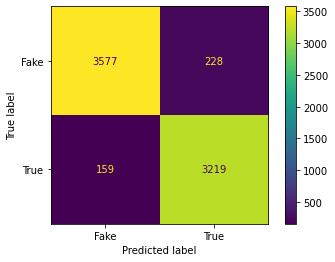

ROC_AUC_SCORE  0.9852674295841765
F1_SCORE 0.9432967032967033
ACCURACY SCORE 0.946122789920646



          METRICS FOR MODEL 1 TITLES



,precision,recall,f1-score,support
Fake,0.990765,0.986859,0.988808,3805.000000
True,0.985264,0.989639,0.987446,3378.000000
accuracy,0.988167,0.988167,0.988167,0.988167
macro avg,0.988014,0.988249,0.988127,7183.000000
weighted avg,0.988178,0.988167,0.988168,7183.000000


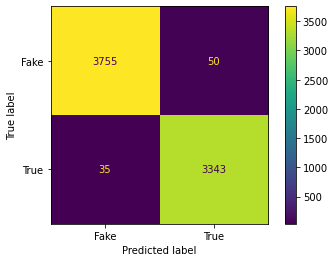

ROC_AUC_SCORE  0.999257466376313
F1_SCORE 0.987446462856299
ACCURACY SCORE 0.9881665042461367





In [14]:
def get_model_predictions(model, test_x, probability = False):

  """ This function takes a pre-trained model in, inputs
      a test set and gets predictions from the model
  Args:    
      model - a pre-trained neural network model
      text_x: - a numpy array of string data
      probability: boolean that if set to True returns probabilities
                   instead of predictions (default = False)
  Returns: 
      predictions - an array of predictions
  """

  predictions = model.predict_on_batch(test_x).flatten()
  # getting a list of predictions into a 1d array
  predictions = tf.nn.sigmoid(predictions)
  # Apply a sigmoid since our model returns logits

  if probability != True:
    # determined whether to return probabilities or predictions
    predictions = tf.where(predictions < 0.5, 0, 1)
    # get the actual predicted values using 0.5 as a threshold

  return predictions.numpy()

  #### TEXT ########

Model_1_Probabilities_Text = get_model_predictions(Model1_Text, val_text, probability = True)
# getting probababilities from function
Model_1_Predictions_Text = get_model_predictions(Model1_Text, val_text, probability = False)
# getting predictions from function

  #### TITLE ########

Model_1_Probabilities_Title = get_model_predictions(Model1_Title, val_title, probability = True)
# getting probababilities from function
Model_1_Predictions_Title = get_model_predictions(Model1_Title, val_title, probability = False)
# getting predictions from function

def display_metrics(y_true, y_pred, y_prob, title = None):
    """ 
        Args: 
          y_true - an array of the actual labels (still needs to numpy)
          y_pred - an array of class predictions 
          y_prob - an array of class probabilities
          title = a string showing a title for the metrics (default = None)
    """

    target_names = ['Fake', 'True']
    # saving classes matching to 0 and 1
    clr = classification_report(y_true.to_numpy(),
                                y_pred,
                                labels=np.arange(2),
                                target_names=target_names,
                                output_dict=True)
    clr_df = pd.DataFrame.from_dict(clr).transpose()
    # saving as data frame and transposing to match string format

    if title != None:
      print("          METRICS FOR %s" %title)
      print("")

    display(clr_df)
    # showing data frame of classification report

    cm = confusion_matrix(y_true.to_numpy(), y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=target_names)
    disp.plot()
    plt.show()
    # showing Confusion Matrix
    print("ROC_AUC_SCORE ", roc_auc_score(y_true, y_prob))
    print("F1_SCORE", f1_score(y_true, y_pred))
    print("ACCURACY SCORE", accuracy_score(y_true, y_pred ))
    print('\n\n')
    # showing AUC, F1 Scores and Accuracy Scores
    return

display_metrics(val_label, 
                Model_1_Predictions_Text, 
                Model_1_Probabilities_Text, 
                title = "MODEL 1 TEXT")
display_metrics(val_label, 
                Model_1_Predictions_Title, 
                Model_1_Probabilities_Title, 
                title = "MODEL 1 TITLES")
# showing metrics for Model 1 text and titles

The first model has a decently high accuracy when trained with the text data and an even higher accuracy when trained with just the data in the titles.

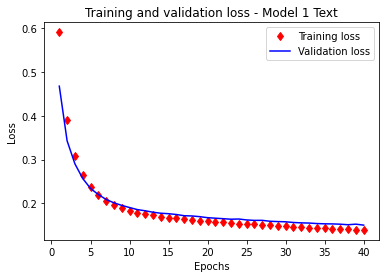

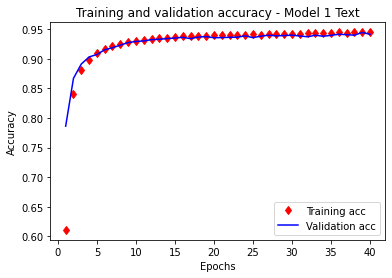

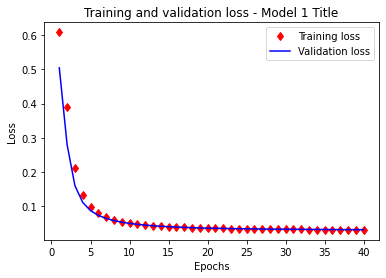

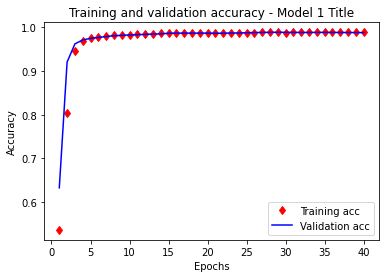

In [15]:
def train_validation_plotter(history, model_name):

  """ Simple plotting function that takes the training history
      of a neural network and make two plots; one showing
      the validation and training loss and the other showing the 
      validation and training accuracy
  """

  history_dict = history.history
  acc = history_dict['accuracy']
  val_acc = history_dict['val_accuracy']
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']
  # saving the history data for plotting
  epochs = range(1, len(acc) + 1)
  # add 1 since history starts from 0

  plt.plot(epochs, loss, 'rd', label='Training loss')
  # shows red diamonds for the training 
  plt.plot(epochs, val_loss, 'blue', label='Validation loss')
  plt.title('Training and validation loss - %s' %model_name)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
  # First plot showing Training and Validation Loss

  plt.plot(epochs, acc, 'rd', label='Training acc')
  # shows red diamonds for the training 
  plt.plot(epochs, val_acc, 'blue', label='Validation acc')
  plt.title('Training and validation accuracy - %s' %model_name)
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()
  # Second plot showing Training and Validation accuracy

train_validation_plotter(Model1_History_Text, "Model 1 Text")
# getting plots for Model 1 Text
train_validation_plotter(Model1_History_Title, "Model 1 Title")
# getting plots for Model 1 Text

In [16]:
################## EXPERIMENT 1 - MODEL 1 TEXT #######################

experiment_df = pd.DataFrame({"Experiment #":["Experiment %s" %(1)],
                                      "Data Set":["Val Text"], 
                                      "Model":["MODEL 1 (7B - nnlm-en-dim50)"],
                                      "Accuracy":[accuracy_score(val_label, 
                                                                 Model_1_Predictions_Text )],
                                      "F1 Score":[f1_score(val_label, 
                                                           Model_1_Predictions_Text)],
                                      "ROC-AUC Score":[roc_auc_score(val_label, 
                                                                     Model_1_Probabilities_Text)]})
# Initializing a dataframe for the experiments and adding

################## EXPERIMENT 2 - MODEL 1 TITLE #######################

experiment_df.loc[len(experiment_df.index)] = \
["Experiment %s" %(2), "Val Title", "MODEL 1 (7B - nnlm-en-dim50)" ,
 accuracy_score(val_label, Model_1_Predictions_Title ), 
 f1_score(val_label, Model_1_Predictions_Title ), 
 roc_auc_score(val_label, Model_1_Probabilities_Title)      ] 
# Adding the new values from this experiment into the experiment_df dataframe

display(experiment_df)

,Experiment #,Data Set,Model,Accuracy,F1 Score,ROC-AUC Score
0,Experiment 1,Val Text,MODEL 1 (7B - nnlm-en-dim50),0.946123,0.943297,0.985267
1,Experiment 2,Val Title,MODEL 1 (7B - nnlm-en-dim50),0.988167,0.987446,0.999257


Now to look at a few other pre-processed model types and add them into the
dataframe. The next one will be a similar model to 7B, but with 128 dimensions instead of 50, and with additional text normalization to remove punctuation. 

## **EXPERIMENTS 3 & 4**

In [17]:
##############################################################################
############  EXPERIMENTS 3 & 4 - MODEL 2 ####################################
############################################################################## 
"""
NOTES ABOUT MODEL 2

Details

Based on NNLM with three hidden layers.

Input

The module takes a batch of sentences in a 1-D tensor of strings as input.

Preprocessing

The module preprocesses its input by removing punctuation and splitting on spaces.

Out of vocabulary tokens

Small fraction of the least frequent tokens and embeddings (~2.5%) are 
replaced by hash buckets. Each hash bucket is initialized using the remaining 
embedding vectors that hash to the same bucket.

Sentence embeddings

Word embeddings are combined into sentence embedding using the sqrtn
combiner (see tf.nn.embedding_lookup_sparse).

References

[1] Yoshua Bengio, Réjean Ducharme, Pascal Vincent, Christian Jauvin. 
A Neural Probabilistic Language Model. Journal of Machine Learning Research, 
3:1137-1155, 2003.

"""

url_128 = 'https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2'

#### TEXT ########

Model2_History_Text, Model2_Text = neural_net_trainer(train_text, train_label, val_text, val_label, url_128)
# fitting article text to English Google News 7B model and saving as Model2 

#### TITLE ########

Model2_History_Title, Model2_Title = neural_net_trainer(train_title, train_label, val_title, val_label, url_128)
# fitting article titles to English Google News 7B model and saving as Model2 




Epoch 1/40
57/57 [==============================] - 3s 49ms/step - loss: 0.4286 - accuracy: 0.7885 - val_loss: 0.3082 - val_accuracy: 0.8968
Epoch 2/40
57/57 [==============================] - 3s 45ms/step - loss: 0.2578 - accuracy: 0.9149 - val_loss: 0.2331 - val_accuracy: 0.9199
Epoch 3/40
57/57 [==============================] - 3s 44ms/step - loss: 0.2069 - accuracy: 0.9323 - val_loss: 0.2006 - val_accuracy: 0.9353
Epoch 4/40
57/57 [==============================] - 2s 43ms/step - loss: 0.1821 - accuracy: 0.9408 - val_loss: 0.1830 - val_accuracy: 0.9424
Epoch 5/40
57/57 [==============================] - 3s 45ms/step - loss: 0.1678 - accuracy: 0.9448 - val_loss: 0.1722 - val_accuracy: 0.9457
Epoch 6/40
57/57 [==============================] - 3s 46ms/step - loss: 0.1581 - accuracy: 0.9473 - val_loss: 0.1664 - val_accuracy: 0.9492
Epoch 7/40
57/57 [==============================] - 3s 45ms/step - loss: 0.1516 - accuracy: 0.9493 - val_loss: 0.1590 - val_accuracy: 0.9470
Epoch 8/40
57

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 128)               124642688 
                                                                 
 dense_4 (Dense)             (None, 16)                2064      
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 124,644,769
Trainable params: 2,081
Non-trainable params: 124,642,688
_________________________________________________________________
225/225 [==============================] - 1s 5ms/step - loss: 0.1200 - accuracy: 0.9573
[0.1199648305773735, 0.9572601914405823]


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3

,precision,recall,f1-score,support
Fake,0.962963,0.956636,0.959789,3805.000000
True,0.951513,0.958555,0.955021,3378.000000
accuracy,0.957539,0.957539,0.957539,0.957539
macro avg,0.957238,0.957596,0.957405,7183.000000
weighted avg,0.957578,0.957539,0.957547,7183.000000


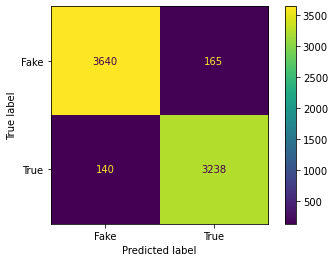

ROC_AUC_SCORE  0.9903504083390324
F1_SCORE 0.9550213832768029
ACCURACY SCORE 0.9575386328831964



          METRICS FOR MODEL 2 TITLES



,precision,recall,f1-score,support
Fake,0.997895,0.996846,0.997370,3805.000000
True,0.996452,0.997632,0.997041,3378.000000
accuracy,0.997216,0.997216,0.997216,0.997216
macro avg,0.997174,0.997239,0.997206,7183.000000
weighted avg,0.997216,0.997216,0.997216,7183.000000


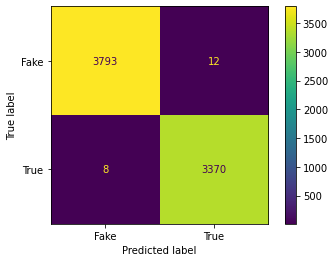

ROC_AUC_SCORE  0.9999307570279672
F1_SCORE 0.9970414201183432
ACCURACY SCORE 0.9972156480579145





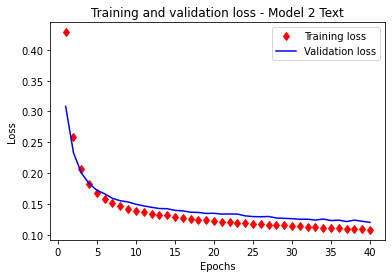

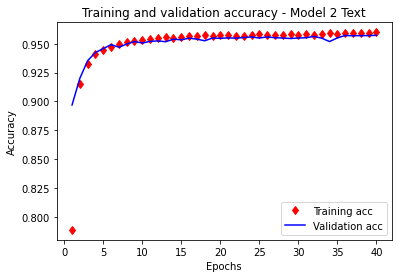

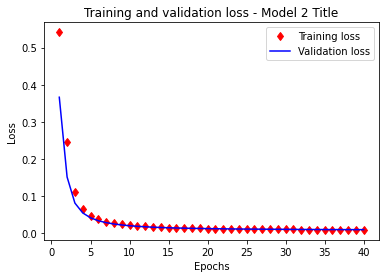

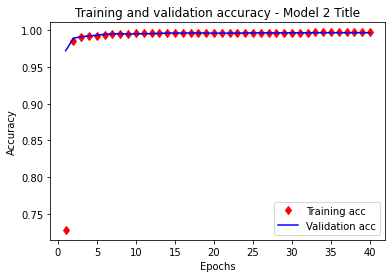

,Experiment #,Data Set,Model,Accuracy,F1 Score,ROC-AUC Score
0,Experiment 1,Val Text,MODEL 1 (7B - nnlm-en-dim50),0.946123,0.943297,0.985267
1,Experiment 2,Val Title,MODEL 1 (7B - nnlm-en-dim50),0.988167,0.987446,0.999257
2,Experiment 3,Val Text,MODEL 2 (nnlm-en-dim128-with-normalization/2),0.957539,0.955021,0.990350
3,Experiment 4,Val Title,MODEL 2 (nnlm-en-dim128-with-normalization/2),0.997216,0.997041,0.999931


In [18]:
##############################################################################
############  EXPERIMENTS 3 & 4 - MODEL 2 ####################################
############################################################################## 

#### TEXT ########

Model2_Text.summary()
# looking at summary for Model1_History_Text
Model_2_Text_Results = Model2_Text.evaluate(val_text, val_label)
print(Model_2_Text_Results)
# looking at the accuracy for the test set using text
print('\n')

#### TITLE ########

Model2_Title.summary()
# looking at summary for Model1_History_Text
Model_2_Title_Results = Model2_Title.evaluate(val_title, val_label)
print(Model_2_Title_Results)
# looking at the accuracy for the test set using titles
  
#### TEXT ########

Model_2_Probabilities_Text = get_model_predictions(Model2_Text, val_text, probability = True)
# getting probababilities from function
Model_2_Predictions_Text = get_model_predictions(Model2_Text, val_text, probability = False)
# getting predictions from function

  #### TITLE ########

Model_2_Probabilities_Title = get_model_predictions(Model2_Title, val_title, probability = True)
# getting probababilities from function
Model_2_Predictions_Title = get_model_predictions(Model2_Title, val_title, probability = False)
# getting predictions from function

display_metrics(val_label, 
                Model_2_Predictions_Text, 
                Model_2_Probabilities_Text, 
                title = "MODEL 2 TEXT")
display_metrics(val_label, 
                Model_2_Predictions_Title, 
                Model_2_Probabilities_Title, 
                title = "MODEL 2 TITLES")
# showing metrics for Model 1 text and titles

train_validation_plotter(Model2_History_Text, "Model 2 Text")
# getting plots for Model 1 Text
train_validation_plotter(Model2_History_Title, "Model 2 Title")
# getting plots for Model 1 Text

################## EXPERIMENT 3 - MODEL 2 TEXT #######################

experiment_df.loc[len(experiment_df.index)] = \
["Experiment %s" %(3), "Val Text", "MODEL 2 (nnlm-en-dim128-with-normalization/2)" ,
 accuracy_score(val_label, Model_2_Predictions_Text ), 
 f1_score(val_label, Model_2_Predictions_Text ), 
 roc_auc_score(val_label, Model_2_Probabilities_Text)      ] 
# Adding the new values from this experiment into the experiment_df dataframe

################## EXPERIMENT 4 - MODEL 2 TITLE #######################

experiment_df.loc[len(experiment_df.index)] = \
["Experiment %s" %(4), "Val Title", "MODEL 2 (nnlm-en-dim128-with-normalization/2)" ,
 accuracy_score(val_label, Model_2_Predictions_Title ), 
 f1_score(val_label, Model_2_Predictions_Title ), 
 roc_auc_score(val_label, Model_2_Probabilities_Title)      ] 
# Adding the new values from this experiment into the experiment_df dataframe

display(experiment_df)

The third experiment will be using one more version of the English Google News 200B corpus with 128 dimensions, but without normalization.

## **EXPERIMENTS 5 & 6**

In [19]:
##############################################################################
############  EXPERIMENTS 5 & 6 - MODEL 3 ####################################
############################################################################## 
"""
NOTES ABOUT MODEL 3

Details

Based on NNLM with three hidden layers.

Input

The module takes a batch of sentences in a 1-D tensor of strings as input.

Preprocessing

The module preprocesses its input by splitting on spaces.

Out of vocabulary tokens

Small fraction of the least frequent tokens and embeddings (~2.5%)
 are replaced by hash buckets. Each hash bucket is initialized using
  the remaining embedding vectors that hash to the same bucket.

Sentence embeddings

Word embeddings are combined into sentence embedding using
 the sqrtn combiner (see tf.nn.embedding_lookup_sparse).

"""

url_200B = "https://tfhub.dev/google/nnlm-en-dim128/2"

#### TEXT ########

Model3_History_Text, Model3_Text = neural_net_trainer(train_text, train_label, val_text, val_label, url_200B)
# fitting article text to English Google News 7B model and saving as Model2 

#### TITLE ########

Model3_History_Title, Model3_Title = neural_net_trainer(train_title, train_label, val_title, val_label, url_200B)
# fitting article titles to English Google News 7B model and saving as Model2 

Epoch 1/40
57/57 [==============================] - 3s 39ms/step - loss: 0.5927 - accuracy: 0.6345 - val_loss: 0.4804 - val_accuracy: 0.8038
Epoch 2/40
57/57 [==============================] - 2s 34ms/step - loss: 0.3904 - accuracy: 0.8567 - val_loss: 0.3243 - val_accuracy: 0.8812
Epoch 3/40
57/57 [==============================] - 2s 33ms/step - loss: 0.2720 - accuracy: 0.9065 - val_loss: 0.2430 - val_accuracy: 0.9145
Epoch 4/40
57/57 [==============================] - 2s 32ms/step - loss: 0.2122 - accuracy: 0.9284 - val_loss: 0.2001 - val_accuracy: 0.9289
Epoch 5/40
57/57 [==============================] - 2s 33ms/step - loss: 0.1807 - accuracy: 0.9384 - val_loss: 0.1769 - val_accuracy: 0.9372
Epoch 6/40
57/57 [==============================] - 2s 33ms/step - loss: 0.1625 - accuracy: 0.9456 - val_loss: 0.1622 - val_accuracy: 0.9413
Epoch 7/40
57/57 [==============================] - 2s 34ms/step - loss: 0.1502 - accuracy: 0.9492 - val_loss: 0.1512 - val_accuracy: 0.9453
Epoch 8/40
57

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_4 (KerasLayer)  (None, 128)               124642688 
                                                                 
 dense_8 (Dense)             (None, 16)                2064      
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                                                                 
Total params: 124,644,769
Trainable params: 2,081
Non-trainable params: 124,642,688
_________________________________________________________________
225/225 [==============================] - 1s 5ms/step - loss: 0.0907 - accuracy: 0.9634
[0.09073010087013245, 0.9633857607841492]


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_

          METRICS FOR MODEL 3 TEXT



,precision,recall,f1-score,support
Fake,0.967411,0.967411,0.967411,3805.000000
True,0.963292,0.963292,0.963292,3378.000000
accuracy,0.965474,0.965474,0.965474,0.965474
macro avg,0.965352,0.965352,0.965352,7183.000000
weighted avg,0.965474,0.965474,0.965474,7183.000000


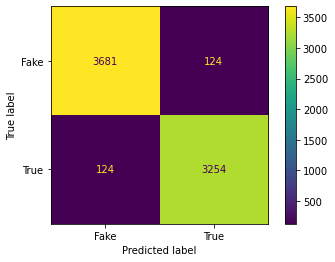

ROC_AUC_SCORE  0.9946679021480103
F1_SCORE 0.9632918886915335
ACCURACY SCORE 0.9654740359181401



          METRICS FOR MODEL 3 TITLES



,precision,recall,f1-score,support
Fake,0.995787,0.993955,0.994870,3805.000000
True,0.993205,0.995263,0.994233,3378.000000
accuracy,0.994571,0.994571,0.994571,0.994571
macro avg,0.994496,0.994609,0.994552,7183.000000
weighted avg,0.994573,0.994571,0.994571,7183.000000


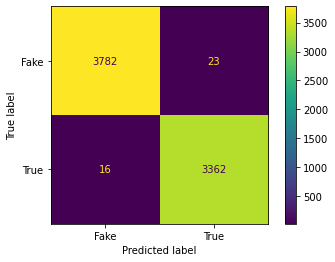

ROC_AUC_SCORE  0.9997452792242297
F1_SCORE 0.9942333284045541
ACCURACY SCORE 0.9945705137129334





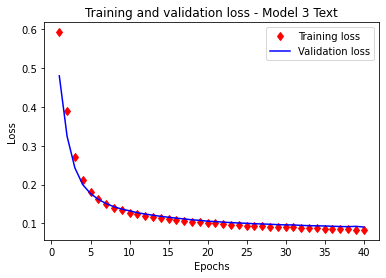

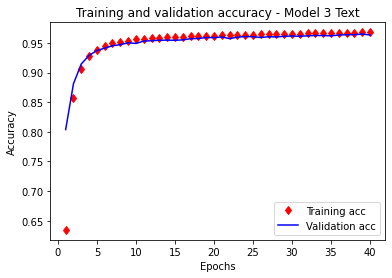

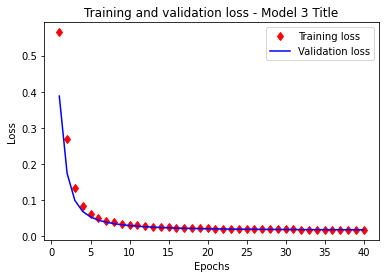

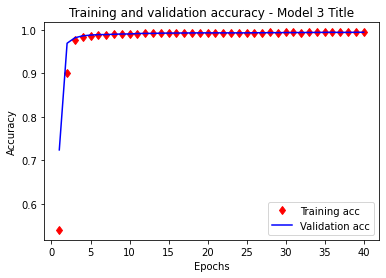

,Experiment #,Data Set,Model,Accuracy,F1 Score,ROC-AUC Score
0,Experiment 1,Val Text,MODEL 1 (7B - nnlm-en-dim50),0.946123,0.943297,0.985267
1,Experiment 2,Val Title,MODEL 1 (7B - nnlm-en-dim50),0.988167,0.987446,0.999257
2,Experiment 3,Val Text,MODEL 2 (nnlm-en-dim128-with-normalization/2),0.957539,0.955021,0.990350
3,Experiment 4,Val Title,MODEL 2 (nnlm-en-dim128-with-normalization/2),0.997216,0.997041,0.999931
4,Experiment 5,Val Text,MODEL 3 (nnlm-en-dim128),0.965474,0.963292,0.994668
5,Experiment 6,Val Title,MODEL 3 (nnlm-en-dim128),0.994571,0.994233,0.999745


In [20]:
##############################################################################
############  EXPERIMENTS 5 & 6 - MODEL 3 ####################################
##############################################################################

#### TEXT ########

Model3_Text.summary()
# looking at summary for Model1_History_Text
Model_3_Text_Results = Model3_Text.evaluate(val_text, val_label)
print(Model_3_Text_Results)
# looking at the accuracy for the test set using text
print('\n')

#### TITLE ########

Model3_Title.summary()
# looking at summary for Model1_History_Text
Model_3_Title_Results = Model3_Title.evaluate(val_title, val_label)
print(Model_3_Title_Results)
# looking at the accuracy for the test set using titles
  
#### TEXT ########

Model_3_Probabilities_Text = get_model_predictions(Model3_Text, val_text, probability = True)
# getting probababilities from function
Model_3_Predictions_Text = get_model_predictions(Model3_Text, val_text, probability = False)
# getting predictions from function

  #### TITLE ########

Model_3_Probabilities_Title = get_model_predictions(Model3_Title, val_title, probability = True)
# getting probababilities from function
Model_3_Predictions_Title = get_model_predictions(Model3_Title, val_title, probability = False)
# getting predictions from function

display_metrics(val_label, 
                Model_3_Predictions_Text, 
                Model_3_Probabilities_Text, 
                title = "MODEL 3 TEXT")
display_metrics(val_label, 
                Model_3_Predictions_Title, 
                Model_3_Probabilities_Title, 
                title = "MODEL 3 TITLES")
# showing metrics for Model 1 text and titles

train_validation_plotter(Model3_History_Text, "Model 3 Text")
# getting plots for Model 1 Text
train_validation_plotter(Model3_History_Title, "Model 3 Title")
# getting plots for Model 1 Text

################## EXPERIMENT 3 - MODEL 2 TEXT #######################

experiment_df.loc[len(experiment_df.index)] = \
["Experiment %s" %(5), "Val Text", "MODEL 3 (nnlm-en-dim128)" ,
 accuracy_score(val_label, Model_3_Predictions_Text ), 
 f1_score(val_label, Model_3_Predictions_Text ), 
 roc_auc_score(val_label, Model_3_Probabilities_Text)      ] 
# Adding the new values from this experiment into the experiment_df dataframe

################## EXPERIMENT 4 - MODEL 2 TITLE #######################

experiment_df.loc[len(experiment_df.index)] = \
["Experiment %s" %(6), "Val Title", "MODEL 3 (nnlm-en-dim128)" ,
 accuracy_score(val_label, Model_3_Predictions_Title ), 
 f1_score(val_label, Model_3_Predictions_Title ), 
 roc_auc_score(val_label, Model_3_Probabilities_Title)      ] 
# Adding the new values from this experiment into the experiment_df dataframe

display(experiment_df)

# **MODEL STACKING USING WEIGHTED PROBABILITY SCORES**

From these experiments, it appears as if **Model 3** has the highest scoring on the validation set using the **Text** data, and **Model 2** has the highest scoring using the **Title** data. It is quite tempting to only use the data from the **Title** due to the extremely high accuracies in all three models, but we will try to see if weighting the probabilities from both the **Text** using **Model 3** and the **Title** using **Model 2** can increase it even further. 

In [21]:
def probability_weighter(text_probs, title_probs, text_weight, title_weight):

  """ This function returns a single array of weighted probabilities
      generated by weighing the probabilities of both the title and the text
      probabilities
  Args:
        text_probs: an array of probabilities from the text data
        title_probs: an array of probabilities from the title data
        text_weight: A float between 0 and 1 that is equal to 1 - title_weight
        title_weight: A float between 0 and 1 that is equal to 1 - text_weight
  Returns:
        weighted_probs: an array of probabilities generated from weighted
        combinations of text and title probabilities

  """
  shape = text_probs.shape
  weighted_probs = np.empty(shape, dtype=float)
  # initializing 1d numpy array to store weighted probabilities in

  for i in range(len(text_probs)):
    weighted_probs[i] = (text_probs[i]*text_weight 
                         + title_probs[i]*title_weight) 
                          # getting weighted probabilities
  return weighted_probs


In [22]:
def get_weighted_scores(text_probs, title_probs, y_true, fine_tune = -1):

  """
  Args:
        text_probs: an array of probabilities from the text data
        title_probs: an array of probabilities from the title data
        y_true: an array of the actual labels
        fine_tune: a negative integer that tells what power of 10 to raise 
        the divisions to (default = -1 for only 10 divisions)
  Returns:
        weight_scores: a dataframe showing the scores for each weighing
  """
  scores = []
  # initialize a list

  for i in range(10):
    text_wt = i*(10**fine_tune)
    title_wt = 1 - text_wt
    # initializing text and title weights
    wt_probs = probability_weighter(text_probs, 
                                    title_probs, 
                                    text_wt, 
                                    title_wt )
    # get the weighted probabilties
    wt_predicts = tf.where(wt_probs < 0.5, 0, 1)
    # get the actual predicted values using 0.5 as a threshold
    auc = roc_auc_score(y_true, wt_probs)
    f1 = f1_score(y_true, wt_predicts)
    acc= accuracy_score(y_true, wt_predicts )
    # getting metrics
    scores.append((text_wt, title_wt, auc, f1, acc ))
    # add weights and scores into the list

  scores = pd.DataFrame(scores, columns = ['Text Weight', 
                                           'Title Weight', 
                                           'ROC-AUC Score', 
                                           'F1 Score', 
                                           'Accuracy Score'])
                                  # turn the list into a dataframe
  return scores
    
weight_scores = get_weighted_scores(Model_3_Probabilities_Text, 
                                    Model_2_Probabilities_Title, 
                                    val_label)
# getting weighted scores
display(weight_scores)

,Text Weight,Title Weight,ROC-AUC Score,F1 Score,Accuracy Score
0,0.0,1.0,0.999931,0.997041,0.997216
1,0.1,0.9,0.999972,0.997486,0.997633
2,0.2,0.8,0.999978,0.997635,0.997773
3,0.3,0.7,0.999974,0.997930,0.998051
4,0.4,0.6,0.999967,0.998373,0.998469
5,0.5,0.5,0.999957,0.998668,0.998747
6,0.6,0.4,0.999709,0.987592,0.988306
7,0.7,0.3,0.999203,0.980485,0.981623
8,0.8,0.2,0.998501,0.973964,0.975498
9,0.9,0.1,0.997454,0.968324,0.970207


In [23]:
Best_Weights_Row = weight_scores['Accuracy Score'].idxmax()
print(weight_scores.iloc[Best_Weights_Row])

Text Weight       0.500000
Title Weight      0.500000
ROC-AUC Score     0.999957
F1 Score          0.998668
Accuracy Score    0.998747
Name: 5, dtype: float64


We can see that when using a weight of probabilities between the **text** and the **title** we increase our accuracy even further. Let's see if we can get a more precise amount for the weightings

In [24]:
weight_scores2 = get_weighted_scores(Model_3_Probabilities_Text, 
                                    Model_2_Probabilities_Title, 
                                    val_label, fine_tune = -2)
Best_Weights_Row2 = weight_scores2['Accuracy Score'].idxmax()
print(weight_scores2.iloc[Best_Weights_Row2])

Text Weight       0.040000
Title Weight      0.960000
ROC-AUC Score     0.999959
F1 Score          0.997486
Accuracy Score    0.997633
Name: 4, dtype: float64


The scores are not increasing by making the divisions more fine, so we will stick with the results from the first run and save the weights for both the **Text** and **Title**. Now to put everything together and look at the test scores.

# **FINAL MODEL - TEST DATA RESULTS**

,precision,recall,f1-score,support
Fake,0.998934,0.998722,0.998828,4693.000000
True,0.998601,0.998834,0.998717,4287.000000
accuracy,0.998775,0.998775,0.998775,0.998775
macro avg,0.998768,0.998778,0.998773,8980.000000
weighted avg,0.998775,0.998775,0.998775,8980.000000


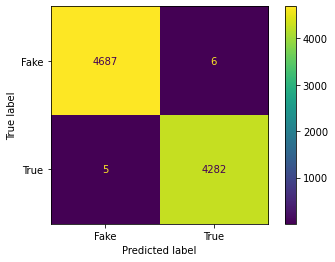

ROC_AUC_SCORE  0.9999661512157902
F1_SCORE 0.9987172011661807
ACCURACY SCORE 0.9987750556792873





In [25]:
Best_Weight_Text = weight_scores.iloc[Best_Weights_Row][0]
Best_Weight_Title = weight_scores.iloc[Best_Weights_Row][1]
Best_Model_Txt = Model3_Text
Best_Model_Title = Model2_Title
# saving models and weights 

def Model_tester(test_text, test_title, y_true):

    """ this function takes in two numpy arrays, puts them
        into the models chosen above with their weights
        and returns the AUC Score, F1 Score and 
        Accuracy Scores

    Args:
        test_text: a numpy array containing strings showing
                    article content 
        test_title: a numpy array containing strings showing
                    article title
        test_labels: a numpy array showing the actual label
                      corresponding to the test_text and 
                      test_title
    """

    probabilities_text = get_model_predictions(Best_Model_Txt, 
                                               test_text, 
                                               probability = True)
    # getting text probababilities from function

    probabilities_title = get_model_predictions(Best_Model_Title, 
                                                 test_title, 
                                                 probability = True)
    # getting title probababilities from function

    wt_probs = probability_weighter(probabilities_text, 
                                        probabilities_title, 
                                        Best_Weight_Text, 
                                        Best_Weight_Title )
    # get the weighted probabilties

    wt_predicts = tf.where(wt_probs < 0.5, 0, 1)
    # get the actual predicted values using 0.5 as a threshold

    auc_test = roc_auc_score(test_label, wt_probs)
    f1_test = f1_score(test_label, wt_predicts)
    acc_test = accuracy_score(test_label, wt_predicts )
    # saving metrics
    display_metrics(y_true, wt_predicts, wt_probs )
    # print results

Model_tester(test_text, test_title, test_label)
# entering the unseen test data into the function 

Our test scores are extremely high for our stacked model, and they are quite similar to our validation set, so the model performs well on unseen data as well.

# **SAVING MODELS FOR LATER USE**

In [26]:
Best_Model_Txt.save("cnn_model_txt.h5")
Best_Model_Title.save("cnn_model_ttle.h5")
# saving models for later use

# **FINAL MODEL TESTS ON OUTSIDE DATA SOURCES**

Now to see how this might work with articles that aren't in the dataset on **kaggle.com** We will make a function to put in the url of an article and see how well the model predicts using the **title** and the **text** of the article. These articles are from various sources that are known to have real articles and fake articles.

In [27]:
url_1 = "https://www.cnn.com/2022/12/09/politics/mccarthy-speaker-house-republicans-218/?dicbo=v2-38598b93edd52456257c29c599b25410&hpt=ob_blogfooterold"
# this is a real news story from CNN

url_2 = 'https://www.bbc.com/news/world-europe-63936360'
# this is also real news story from the BBC

url_3 = "https://www.theonion.com/elon-musk-worried-he-won-t-have-enough-twitter-employee-1849870554"
# this is a fake news story from The Onion written for comedic effect

url_4 = "https://expose-news.com/2022/11/24/secret-cdc-report-1million-americans-died-suddenly-covid-vaccine/"
# this is also a fake news story from about COVID vaccines that circulated around Instagram and 
# designed to spread misinformation

url_5 = "https://www.theguardian.com/world/2022/dec/11/ukrainian-himars-missiles-hit-russian-occupied-melitopol"
# this is a real news story from The Guardian

url_6 = "https://www.nytimes.com/2022/12/11/us/politics/louisiana-prison-overdetention.html"
# this is a real news story from The New York Times

url_7 = "https://www.nytimes.com/2022/12/11/world/europe/germany-prince-heinrich-xiii.html"
# this is a real news story from The New York Times

url_8 = "https://hard-drive.net/elon-musk-admits-he-wants-to-travel-to-mars-because-no-one-hates-him-there-yet/"
# this is a fake new story written for comedic effect

url_list = [url_1, url_2, url_3, url_4, url_5, url_6, url_7, url_8]

In [28]:
def news_classifier(url):
  """ This is a function that takes in a news url, parses the text and title 
      from the article in the url, and then uses the two pre-trained neural 
      network models and their optimized weight parameters to determine the 
      probability that a news article is real 
  Args:
        url - a url string pointing to a news article
  Returns:
        wt_prob - a float between 0 and 1 referring to the probability
                  that the article is true or not
  """
  article = Article(url)
  article.download()
  article.parse()
  # downloading the article and parsing 
  # in order to get the title and text

  text = np.array([article.text])
  title = np.array([article.title])
  # saving the text and title as arrays in
  # order for the model to be able to read them

  text_prob = get_model_predictions(Best_Model_Txt, 
                                    text, 
                                    probability = True)
  title_prob = get_model_predictions(Best_Model_Title, 
                                     title, 
                                     probability = True)
  wt_prob =   probability_weighter(text_prob, 
                                   title_prob, 
                                   Best_Weight_Text, 
                                   Best_Weight_Title)
  # getting text and title probabilities from the models 
  # and then getting the final weighted probability from 
  # the weighting function

  return wt_prob

def fake_or_real(url, threshold = 0.5):
    """ This is a function that takes in a news url, inputs it into
    the news_classifier function and based on the probability returned
    prints a statement saying whether the news article is real or fake 
    based on how the probability compares to the threshold argument

    Args:
        url - a url string pointing to a news article
        threshold - a float between 0 and 1 (default = 0.5)
    """
    url_article = Article(url)
    url_article.download()
    url_article.parse()
    url_title = url_article.title

    prob = news_classifier(url)
    # get the probabilitiy of article being true from the news_classifier
    if prob < threshold:
      print("Fake News Article - ", url_title)
      # anything below 0.5 declared fake unless 
      # threshold altered
    else:
      print("Real News Article - ", url_title)
    # prints Real if prob equal or above threshold

for link in url_list:
  fake_or_real(link)
  print("Probability Score - %s\n" %(news_classifier(link)))

Real News Article -  House Republicans brace for doomsday scenario if McCarthy falls short of 218 votes for speaker
Probability Score - [0.96310228]

Real News Article -  Four suspects charged in probe into European Parliament bribery by Gulf state
Probability Score - [0.99822664]

Fake News Article -  Elon Musk Worried He Won’t Have Enough Twitter Employees Left To Fire On Christmas Eve
Probability Score - [0.1192105]

Fake News Article -  Secret CDC Report reveals at least 1.1 Million Americans have ‘Died Suddenly’ since the COVID Vaccine roll-out & another Government Report proves the COVID Vaccines are to blame
Probability Score - [0.32182707]

Real News Article -  Ukrainian strike hits Russian barracks in occupied Melitopol
Probability Score - [0.99898624]

Fake News Article -  Some Prisoners Remain Behind Bars in Louisiana Despite Being Deemed Free
Probability Score - [0.05560163]

Fake News Article -  The Prince, the Plot and a Long-Lost Reich
Probability Score - [0.32960781]

F

Our model works very well, except for the **urls** from **The New York Times**, as it classified these two articles incorrecly.  However, if one looks at how the urls are structured, notice that the articles from the **New York Times**  has an **html.** at the end of the **url**, and the other articles do not. Most likely this is due to the firewall on the New York Times website that prevents unpaid subscribers from accessing the new articles for free, and when the model is unable to acccess the text or title, it incorrectly categorizes the news as **Fake**

url_5 = "https://www.theguardian.com/world/2022/dec/11/ukrainian-himars-missiles-hit-russian-occupied-melitopol"


url_6 = "https://www.nytimes.com/2022/12/11/us/politics/louisiana-prison-overdetention.html"

Also, notice that the fourth fake news story has a somewhat higher probability that is still below the threshold of **0.5**, but the model is classifying this with a much larger degree of credibility than the humourous fake stories, which shows how convincing and damaging these stories can be.

In order to further test the mdel in the field, a streamlit app was created using the two saved models above called **News_Classifier_App.py**. See the code below, which has been commented as it is ended to be used separately from here.

In [3]:
'''

INSTRUCTIONS FOR CONTINUING ON WITH STREAMLIT

In Terminal

# cd /Users/edwardmiller/Desktop/School\ documents/DATA\ MINING\ FOLDER/Data\ Mining\ Project\ Folder
# streamlit run News_Classifier_App.py

REQUIREMENTS FILE

copy this into requirements.txt

altair==4.2.0
keras==2.11.0
matplotlib==3.6.2
#newspaper==0.1.0.7
newspaper3k==0.2.8
numpy==1.23.5
pandas==1.5.2
seaborn==0.12.1
streamlit==1.15.2
tensorflow==2.11.0
tensorflow_hub==0.12.0

INSTRUCTIONS TO CREATE DOCKERFILE

when docker is running go to working directory

Type in terminal - 

cd '/Users/edwardmiller/Desktop/School documents/DATA MINING FOLDER/Data Mining Project Folder/docker
touch Dockerfile ### IMPORTANT TO DO IT LIKE THIS - use touch command, making a new text file causes errors

Go to newly created Dockerfile and copy this 

FROM python:3.9.12

EXPOSE 8501

WORKDIR /app

COPY . .

RUN pip3 install -r requirements.txt

ENTRYPOINT ["streamlit", "run", "News_Classifier_App.py", "--server.port=8501", "--server.address=0.0.0.0"]

Type in Terminal -

docker build -t news_classifier_app . ### IMPORTANT - DON"T LEAVE OFF THE DOT AT THE END OF THIS COMMAND!
docker run -p 8501:8501 news_classifier_app
http://localhost:8501

'''

'''


############################################################################################
##################        LIBARY IMPORTS                              ######################
############################################################################################
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import zipfile
# basic libraries

import re
import newspaper
from newspaper import Article
# newspaper libraries

import streamlit as st
import altair as alt
# streamlit library

from absl import logging
import tensorflow as tf
import tensorflow_hub as hub
import keras as K
from tensorflow.keras.models import load_model
# tensorflow libraries

############################################################################################
##################        CLASSIICATION FUNCTIONS                     ######################
############################################################################################

#@st.experimental_memo(show_spinner=False)
# cache to make app run faster
def Load_Models():
    """
    Loads pretrained models for news classification

    """

    text_model = load_model("cnn_model_txt.h5",
                            custom_objects={'KerasLayer':hub.KerasLayer})
    title_model = load_model("cnn_model_ttle.h5",
                             custom_objects={'KerasLayer':hub.KerasLayer})
    # load models

    return text_model, title_model

Best_Model_Txt, Best_Model_Title = Load_Models()
# Load in the pretrained models

def get_model_predictions(model, test_x, probability = False):

  """ This function takes a pre-trained model in, inputs
      a test set and gets predictions from the model
  Args:    
      model - a pre-trained neural network model
      text_x: - a numpy array of string data
      probability: boolean that if set to True returns probabilities
                   instead of predictions (default = False)
  Returns: 
      predictions - an array of predictions
  """

  predictions = model.predict_on_batch(test_x).flatten()
  # getting a list of predictions into a 1d array
  predictions = tf.nn.sigmoid(predictions)
  # Apply a sigmoid since our model returns logits

  if probability != True:
    # determined whether to return probabilities or predictions
    predictions = tf.where(predictions < 0.5, 0, 1)
    # get the actual predicted values using 0.5 as a threshold

  return predictions.numpy()

def probability_weighter(text_probs, title_probs, text_weight, title_weight):

  """ This function returns a single array of weighted probabilities
      generated by weighing the probabilities of both the title and the text
      probabilities
  Args:
        text_probs: an array of probabilities from the text data
        title_probs: an array of probabilities from the title data
        text_weight: A float between 0 and 1 that is equal to 1 - title_weight
        title_weight: A float between 0 and 1 that is equal to 1 - text_weight
  Returns:
        weighted_probs: an array of probabilities generated from weighted
        combinations of text and title probabilities

  """
  shape = text_probs.shape
  weighted_probs = np.empty(shape, dtype=float)
  # initializing 1d numpy array to store weighted probabilities in

  for i in range(len(text_probs)):
    weighted_probs[i] = (text_probs[i]*text_weight 
                         + title_probs[i]*title_weight) 
                          # getting weighted probabilities
  return weighted_probs

def news_classifier(url):
  """ This is a function that takes in a news url, parses the text and title 
      from the article in the url, and then uses the two pre-trained neural 
      network models and their optimized weight parameters to determine the 
      probability that a news article is real 
  Args:
        url - a url string pointing to a news article
  Returns:
        wt_prob - a float between 0 and 1 referring to the probability
                  that the article is true or not
  """
  article = Article(url)
  article.download()
  article.parse()
  # downloading the article and parsing 
  # in order to get the title and text

  text = np.array([article.text])
  title = np.array([article.title])
  # saving the text and title as arrays in
  # order for the model to be able to read them

  text_prob = get_model_predictions(Best_Model_Txt, 
                                    text, 
                                    probability = True)
  title_prob = get_model_predictions(Best_Model_Title, 
                                     title, 
                                     probability = True)
  wt_prob =   probability_weighter(text_prob, title_prob, 0.500, 0.500)
  # getting text and title probabilities from the models 
  # and then getting the final weighted probability from 
  # the weighting function

  return wt_prob

############################################################################################
##################            STREAMLIT FUNCTIONS                     ######################
############################################################################################

st.markdown("<h1 style='text-align: center; color: blue; font-size: 50px; '>NEWS CLASSIFIER APP</h1>",
            unsafe_allow_html=True)
# shows title bar of the app on the screen

url = st.text_input(
    'This is an app under development to check the credibility of a news article url - Please enter a news article url below')
# gets url inpur from the user
  
def get_article_info(url):
    """  This function uses the newspaper libarary functionality
         to download the content of a website url and return the
         title and text of that website
    Args:
        url - a string containing a url pointing to a news article
    Returns:
        title - a string containing the title of the article
                the url is pointing to
        text - a string containing the title of the article
                the url is pointing to               
  """

    article = Article(url) 
    article.download()
    # download the article with libary newspaper Article functionality
    article.parse() # look through article to get necessary sections
    title = article.title 
    text = article.text 
    # downloading the article
    # and getting the title and text
    # from it
    return title, text

def make_probability_side_bar(title, text, prob_score):
    """  This function uses the title and text returned by
             the get_article_info() function along with the probability score
             returned by the news_classifier() function to create a sidebar on
             the left of the screen in the streamlit app showing the article's
             probability of being real or not according to the model
             along with a bar chart showing it on the scale 0 to 1
    Args:
        title - a string containing the title of an article from the url
        text - a string containing the text of an article from the url
        prob_score = a float show probability score given by model
    """
        
    head = '<h2 style="text-align: center;"font-family:sans-serif; ">Model Probability of Being True</p>'
    st.sidebar.markdown(head, unsafe_allow_html=True)
    # sidebar title

    Prob_Df = pd.DataFrame({'Article': [title],
                            'Probability of Article Being True': [float(prob_score)],})
    # making dataframe in order to use altair bar chart

    st.sidebar.write(alt.Chart(Prob_Df,width = {"step": 275})
                     .mark_bar()
                     .configure_axis(title=None)
                     .encode(
            x = alt.X('Article', sort= None, axis=alt.Axis(labels=False)), 
            y = alt.Y('Probability of Article Being True',
                      scale=alt.Scale(domain=[0.0,1.0]),
                      # ensures y bar only goes between 0 and 1
                      sort= None),
            color = alt.condition(
                alt.datum['Probability of Article Being True'] < 0.5,
                alt.value('red'),
                alt.value('green'))
                # color is red if below 0.5
                # and green if equal or above 0.5
            ))
    # sidebar showing probability on scale of 0 to 1
    st.sidebar.write("Probability Score - ", float(prob_score))

def side_bar_header(title, text, prob_score):
    """  This function uses the title and text returned by
        the get_article_info() function along with the probability score
        returned by the news_classifier() function to create a sidebar header on the left
        of the screen in the streamlit app which prints 'PROBABLY TRUE' if prob_score 0.5
        or greater, 'PROBABLY FALSE' if less then 0.5 and 'NO DATA'
        if the title or text are blank
    Args:
        title - a string containing the title of an article from the url
        text - a string containing the text of an article from the url
        prob_score = a float show probability score given by model
    """
    if title == '' or text == '':
        new_title = '<p style="font-family:sans-serif; text-align: center; color:Blue; font-size: 42px;">NO DATA</p>'
        st.sidebar.markdown(new_title, unsafe_allow_html=True)
        # accounts for when the function cannot read the article
        # does not make a sidebar here

    elif prob_score >= 0.5:
        new_title = '<p style="font-family:sans-serif; text-align: center; color:Green; font-size: 42px;">PROBABLY TRUE</p>'
        st.sidebar.markdown(new_title, unsafe_allow_html=True)
        make_probability_side_bar(title, text, prob_score)
        # true articles - makes a sidebar showing probability 

    else:
        new_title = '<p style="font-family:sans-serif; text-align: center; color:Red; font-size: 42px;">PROBABLY FALSE</p>'
        st.sidebar.markdown(new_title, unsafe_allow_html=True)
        make_probability_side_bar(title, text, prob_score)
        # false articles - makes a sidebar showing probability 
    
    # True/False headings for article

def run_app(url):
    """ This is the main function for the streamlit app. If the url section is not blank
        it runs the app and prints  the title and text of the articl to the screen
        and also outputs the pre-trained model's prediction as to whether the article is
        is real or not along with a probability sidebar showing how probable it is that it
        is a real article

    Args:
        url - a string input given by the user that points to a news article

    """
    if url != '':
        # app only starts running if url is not blank
        # prevents errors at start 
        title, text = get_article_info(url)
        # getting title and text only
        prob_score = news_classifier(url)
        # getting probability score for news article

        if prob_score < 0.5:
                    # make title and text labels red if article labeled False
                    st.markdown("<h2 style='text-align: center; color: red; font-size: 50px; '>Title</h1>",
                                unsafe_allow_html=True)
                    st.header(title)
                    st.write("---------------------------------")
                    st.markdown("<h2 style='text-align: center; color: red; font-size: 50px; '>Text</h1>",
                                unsafe_allow_html=True)
        else:
                    # make title and text labels green if article labeled True
                    st.markdown("<h2 style='text-align: center; color: green; font-size: 50px; '>Title</h1>",
                                unsafe_allow_html=True)
                    st.header(title)
                    st.write("---------------------------------")
                    st.markdown("<h2 style='text-align: center; color: green; font-size: 50px; '>Text</h1>",
                                unsafe_allow_html=True)  
        st.subheader(text)
        # show article title and text
        side_bar_header(title, text, prob_score)
        # shows the header and whether article Fake or Real
        # will generate a probability sidebar unless no data
        # obtained by url
        
run_app(url) 
# run the app


'''


'\n\n\n############################################################################################\n##################        LIBARY IMPORTS                              ######################\n############################################################################################\nimport matplotlib.pyplot as plt\nimport numpy as np\nimport pandas as pd\nimport seaborn as sns\nimport zipfile\n# basic libraries\n\nimport re\nimport newspaper\nfrom newspaper import Article\n# newspaper libraries\n\nimport streamlit as st\nimport altair as alt\n# streamlit library\n\nfrom absl import logging\nimport tensorflow as tf\nimport tensorflow_hub as hub\nimport keras as K\nfrom tensorflow.keras.models import load_model\n# tensorflow libraries\n\n############################################################################################\n##################        CLASSIICATION FUNCTIONS                     ######################\n#############################################################

# **FIELD TEST NOTES**

Some field tests of the app yielded some interesting results that show that there is still much work to be done, in order to make this model useful in any practical context.

The app works quite well when looking at satyrical websites, such as **The Onion** and **hard-drive.net**, and generally works well when being tested on **The Guardian** and **BBC**. However, it had issues parsing the **CNN** website and as mentioned above **The New York Times** and would not be able to give any kind of score or would give a **False** reading based on the urls alone. Even when a link from **Weather.com** was tested, the classifier returned a result of **False** and gave an extremely low probability score as well. 

These results could have multiple causes and/or a combination of theses causes. The first cause could be the way that the newspaper function scrapes the articles from the wesbites, as many websites have firewalls to protect from malicious attacks from malware and spyware. The second possible cause could be that the model is very well trained on real articles from **Reuters**, but they are not well trained on data from other new sources, and thus the model will classify most things that deviate too far from the style used by **Reuters** as **False**. 

The way to test improve these results would be to retrain the neural network on a more diverse set of real news articles, in order for it to learn the formats used by news sources other than **Reuters**. Also, the news scraper function deployed above would need to be able to find a way to bypass the firewalls and paywalls for some of these urls, which is quite unlikely without permission from these sources, as they depend on some kind of revenue from online subscriptions. 

# **CONCLUSIONS**

The power of transfer learning and neural networks for text classification is quite impressive and when being used on a relatively uniform set of data, they can be used to very accurately classify whether a news story is real or fake based on the title and text in the article alone. However, even though the model performed extremely well in a test environment with unseen data, it struggled in the field for the reasons above. An important lesson can be taken from this. Even if a model's performance works well in a contained experiment such as what was used above, if not tested in the field before deployment, one can make costly mistakes by prematurely deploying something not ready for production.

